In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

## Цель ресерча

Главная цель этого ресерча - познакомиться с алгоритмами заполнения пропусков и оценить, как хорошо они восстанавливают данные. Пропущенные значения в датасете генерируются искусственно и рандомно - MSAR (без связи с каким либо известным\неизвестным фактором). После восстановленние на этих данных строится классификация. 

## Загрузка библиотек

    !pip install scikit-learn==0.22.2.post1

    !pip install missingno

In [2]:
from missingpy import MissForest

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/alexandra/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib as plt 
%matplotlib inline

import statistics  

from tqdm import tqdm

from itertools import product

In [4]:
from sklearn import tree
from sklearn import metrics

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error

from sklearn.impute import KNNImputer

    !sudo apt-get update
    !sudo apt-get install graphviz
    !sudo apt --fix-broken install
    !pip install graphviz

In [5]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

from IPython.display import HTML
style = "<style>svg{width:40% !important; height: 60% !important;}</style>"
HTML(style)

## Загрузка датасета 

    https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

In [6]:
X = pd.read_csv('ds_salaries.csv')
X.shape

(607, 12)

## Подготовка датасета 

In [7]:
X.drop_duplicates().shape

(607, 12)

In [8]:
X.isna().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Упрощаем нашу задачу - оставляем только 2 класса ("младшие" - Junior и Middle, "старшие" - Senior и Expert) 

In [9]:
Y = X['experience_level'].map({'EX': '1', 'EN': '0', 'SE': '1', 'MI': '0'})

In [10]:
Y.value_counts()

1    306
0    301
Name: experience_level, dtype: int64

In [11]:
X['location_IsMatched'] = (X['company_location'] != X['employee_residence']).apply(int)

X['company_size'] = X['company_size'].map({'S': 0, 'M': 50, 'L': 250})

X = pd.concat([X, pd.get_dummies(X['employment_type'], prefix='employment_type')], axis=1)

In [12]:
del X['employee_residence']
del X['company_location']
del X['Unnamed: 0'] 
del X['salary_currency']
del X['salary']
del X['experience_level'] 
del X['job_title']
del X['employment_type']

In [13]:
X[:3]

,work_year,salary_in_usd,remote_ratio,company_size,location_IsMatched,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT
0,2020,79833,0,250,0,0,0,1,0
1,2020,260000,0,0,0,0,0,1,0
2,2020,109024,50,50,0,0,0,1,0


In [14]:
print('Медиана по всем наблюдениям:', X['salary_in_usd'].median())
print('Медиана по "младшим":', X[Y == '0']['salary_in_usd'].median())
print('Медиана по "старшим:"', X[Y == '1']['salary_in_usd'].median())

Медиана по всем наблюдениям: 101570.0
Медиана по "младшим": 70912.0
Медиана по "старшим:" 137067.5


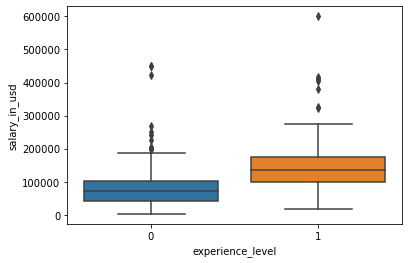

In [15]:
ax = sns.boxplot(x=Y, y=X['salary_in_usd'])

## Функции 

### Подбор гиперпараметра max_depth  для модели DecisionTreeClassifier с помощью GridSearchCV

In [16]:
def best_decision_tree_classifier(X_train, X_test, y_train, y_test, inform=True): 
    
    model = DecisionTreeClassifier(random_state=42)
    
    params_set = {
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    }

    grid_CV = GridSearchCV(
        estimator=model,
        param_grid=params_set,
        scoring='accuracy', 
        cv=5,
        n_jobs=-1
    )

    grid_CV.fit(X_train, y_train)
    
    best_model = grid_CV.best_estimator_ 
    max_depth = grid_CV.best_params_['max_depth']
    train_score = grid_CV.best_score_
    test_score = grid_CV.best_estimator_.score(X_test,y_test)
    importance = grid_CV.best_estimator_.feature_importances_[1]# нужно сделать универсально 
    
    if inform:
        model_info(grid_CV)

    return grid_CV, train_score, test_score, max_depth, importance


### Отображение результатов результатов модели 

In [17]:
def model_info(gsv):
    
    array_proba = gsv.best_estimator_.predict_proba(X_test)
    p = (array_proba > 0.8).sum() / array_proba.size
    
    y_pred_train = gsv.best_estimator_.predict(X_train)
    y_pred_test = gsv.best_estimator_.predict(X_test)
    
    report = metrics.classification_report(y_pred_test, y_test)
    
    print(f'Лучшие значения гиперпараметров: {gsv.best_params_}')
    print(f'Лучшая метрика на train: {gsv.best_score_:.4f}')
    print(f'Лучшая метрика на test: {gsv.best_estimator_.score(X_test,y_test):.4f} \n')
    print(f'Доля наблюдений, для которых есть класс, вероятность принадлежать которому больше 0.8: {p:.4f} \n')
    print(metrics.classification_report(y_pred_test, y_test))

    cm = confusion_matrix(y_test, y_pred_test, labels=gsv.best_estimator_.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gsv.best_estimator_.classes_)
    disp.plot()
    

### Работа со сводной таблицей 

In [18]:
def create_empty_table(): 
    cols = ['experiment', '% nan', 'nan_mae', 'nan_mae_std', 'train_score', 'train_score_std', 
            'test_score', 'test_score_std', 'max depth', 'importance', 'importance_std']
    return pd.DataFrame(columns=cols)


In [19]:
def add_row(df, exp, nan, nan_mae, nan_mae_std, 
            train_score, train_score_std, test_score, test_score_std, 
            max_depth, importance, importance_std): 
    
    new_row = {'experiment': exp, 
               '% nan': nan, 
               'nan_mae': nan_mae, 
               'nan_mae_std': nan_mae_std, 
               'train_score': train_score, 
               'train_score_std': train_score_std, 
               'test_score': test_score, 
               'test_score_std': test_score_std, 
               'max depth': max_depth, 
               'importance': importance,
               'importance_std': importance_std
              }
    
    return df.append(new_row, ignore_index=True)


### Генерация пропущенных значений 

In [20]:
def add_nan_values(df, col, nan_percent, random_state):
    
    import random
    
    rng = np.random.RandomState(random_state)

    none_values = [(rng.randint(0, df.shape[0] - 1)) for i in range(int(df.shape[0] * nan_percent))]
    
    df_copy = df.copy()
    df_copy.loc[df_copy.index[none_values], col] = np.nan
    
    return df_copy


### Основная функция  

При оценке алгоритмов хочется оценивать и их погрешность, которая возникает из-за случайности, поэтому здесь представлен цикл по random state. 

В рамках каждого цикла в колонку salary_in_usd случайным образом добавляется выбранное кол-во нанов, а выбранный алгоритм их заполняет. Затем на основе восстановленных данных проводится подбор гипарпараметров (в нашем случае только одного, max_depth) для модели DecisionTreeClassifier. Все важные скоры сохраняются. На выходе из цикла мы получаем строку в сводной таблице, в которой представлены лучшие скоры и их усреднения по всем random state (погрешность). 


In [21]:
def exp_loop(X_train, X_test, y_train, y_test, table, exp_name, nan, algo, n_iter, col='salary_in_usd', inform=True):

    exp_dict = {}

    for random_state in range(100, 100+n_iter):
        
        
        X_miss = add_nan_values(X_train, col, nan, random_state)
        X_algo = algo(X_miss, col)
        mae = mean_absolute_error(X_train[col], X_algo[col])

        
        res = best_decision_tree_classifier(X_algo, X_test, y_train, y_test, inform=False)

        exp_dict[random_state] = res + (round(mae), )
        
    best_key = max(exp_dict, key=lambda x: exp_dict.get(x)[2]) # use test score
    best_res = exp_dict[best_key]

    table = add_row(
        table, exp_name, 
        nan*100, best_res[5], round(statistics.stdev([i[5] for i in exp_dict.values()])), # nan 
        best_res[1], statistics.stdev([i[1] for i in exp_dict.values()]), # test score
        best_res[2], statistics.stdev([i[2] for i in exp_dict.values()]), # test score
        best_res[3], # max depth
        best_res[4], statistics.stdev([i[4] for i in exp_dict.values()])) # importance
                    
    if inform:
        model_info(exp_dict[best_key][0])
    
    return table


### Алгоритмы заполнения пропущенных значений

#### Median

In [22]:
def impute_with_median(df, col): 
    df_copy = df.copy()
    df_copy[col] = df_copy[col].fillna(round(df_copy[col].median()))
    return df_copy


#### Значение -1

In [23]:
def impute_with_fixed_value(df, col): 
    df_copy = df.copy()
    df_copy[col] = df_copy[col].fillna(-1)
    return df_copy


#### Random

Заполнение рандомными значениями, которые уже были в датасете

In [24]:
def impute_with_random_value(df, col): 
    df_copy = df.copy()
    
    n_nans = df_copy[col].isna().sum() 
    
    replace = df_copy.loc[df_copy[col].notna(), col].sample(n_nans, replace=True).to_list()

    df_copy.loc[df_copy[col].isna(), col] = replace

    return df_copy


#### Hot desk

In [25]:
def impute_hot(df, col): 
    df_copy = df.copy()
    df_copy.fillna(method='ffill', inplace=True)
    df_copy.fillna(method='bfill', inplace=True)
    return df_copy


#### KNN

In [26]:
def impute_knn(df, col): 
    
    df_copy = df.copy()
    
    imputer = KNNImputer(n_neighbors=2)

    df_copy[col] = imputer.fit_transform(df_copy[[col]])
    
    return df_copy


#### Random Forest

In [27]:
def impute_forest(df, col): 
    
    df_copy = df.copy()
    
    imputer = MissForest(max_iter=100, random_state=42, n_jobs=-1,)
    
    df_copy = imputer.fit_transform(df_copy)
    
    return pd.DataFrame(df_copy, columns=df.columns)


## Решение

In [28]:
table = create_empty_table()
table

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=20082022)

### Baseline

Для оценки качества классификации, обученной на восстановленных данных, нужно некоторое "нулевое" решение

Лучшие значения гиперпараметров: {'max_depth': 4}
Лучшая метрика на train: 0.7464
Лучшая метрика на test: 0.7363 

Доля наблюдений, для которых есть класс, вероятность принадлежать которому больше 0.8: 0.2836 

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       109
           1       0.70      0.75      0.72        92

    accuracy                           0.74       201
   macro avg       0.74      0.74      0.74       201
weighted avg       0.74      0.74      0.74       201



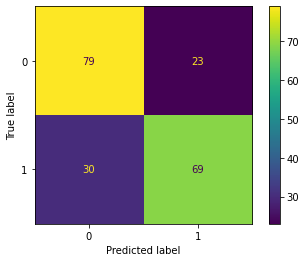

In [30]:
res = best_decision_tree_classifier(X_train, X_test, y_train, y_test)

table = add_row(table, 'full dataset', 0, 0, 0, res[1], 0, res[2], 0, res[3], res[4], 0)

In [31]:
graph = Source(
    tree.export_graphviz(
        res[0].best_estimator_, 
        out_file=None, 
        feature_names = list(X),
        class_names= ['0', '1'],
        filled = True 
    )
) 

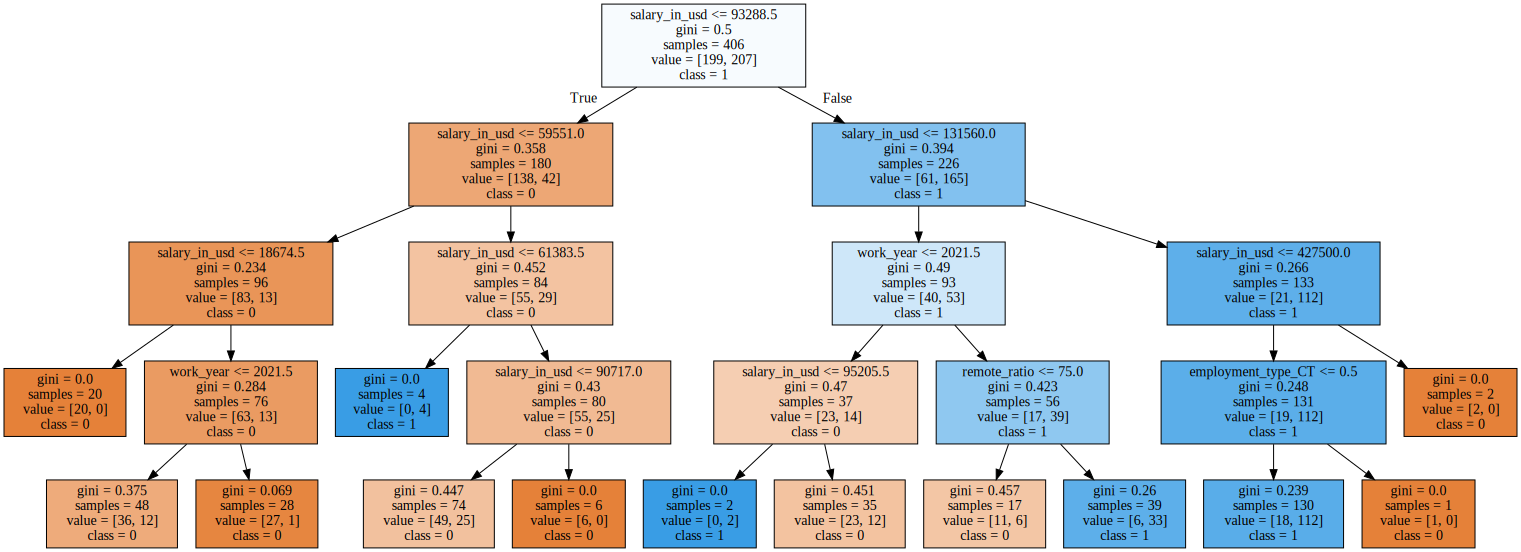

In [32]:
display(SVG(graph.pipe(format='svg')))

### Алгоритмы заполнения пропусков 

Пробежимся по всем алгоритмам заполнения пропусков, каждый алгоритм попробует восстановить 10%, 25%, 33% и 50% пропусков. 

In [33]:
dict_algo ={'random': impute_with_random_value, 
            'value -1': impute_with_fixed_value, 
            'median': impute_with_median, 
            'hot desk': impute_hot,
            'knn': impute_knn, 
            'forest': impute_forest
           }

product_list = list(product(list(dict_algo.keys()), [0.1, 0.25, 0.33, 0.5]))
len(product_list)

24

In [34]:
for exp_name, nan in tqdm(product_list):
    
    table = exp_loop(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, inform=False,
                 table=table, exp_name=exp_name, nan=nan, algo=dict_algo[exp_name], n_iter=10)

 83%|███████████████████████████████████▊       | 20/24 [00:47<00:10,  2.50s/it]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 88%|█████████████████████████████████████▋     | 21/24 [01:09<00:24,  8.29s/it]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 92%|███████████████████████████████████████▍   | 22/24 [01:31<00:24, 12.29s/it]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2


 96%|█████████████████████████████████████████▏ | 23/24 [01:51<00:14, 14.84s/it]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2


100%|███████████████████████████████████████████| 24/24 [02:13<00:00,  5.57s/it]


### Сводная таблица и анализ

In [35]:
table

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
0,full dataset,0,0,0,0.746402,0,0.736318,0,4,0.843099,0
1,random,10.0,5926,780,0.731527,0.013455,0.761194,0.019404,3,0.838728,0.031432
2,random,25.0,14446,952,0.696899,0.022839,0.781095,0.026945,3,0.722095,0.072015
3,random,33.0,17828,1594,0.69467,0.023548,0.761194,0.028265,3,0.74166,0.052258
4,random,50.0,28725,2298,0.697079,0.021241,0.776119,0.033828,3,0.672996,0.072246
5,value -1,10.0,11212,823,0.726528,0.017971,0.766169,0.016113,4,0.812194,0.061152
6,value -1,25.0,24435,1577,0.684643,0.017112,0.766169,0.016551,3,0.790036,0.058361
7,value -1,33.0,29526,2292,0.702138,0.015162,0.756219,0.022026,3,0.835679,0.062921
8,value -1,50.0,41623,2553,0.714273,0.01663,0.766169,0.029312,5,0.723218,0.052266
9,median,10.0,4036,412,0.748841,0.013262,0.761194,0.013058,3,0.884156,0.066233


Рейтинг алгоритмов по восстановлению пропущенных значений

In [36]:
table[table['% nan'].isin([0, 10])].sort_values(by=['nan_mae'])

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
0,full dataset,0,0,0,0.746402,0,0.736318,0,4,0.843099,0
9,median,10.0,4036,412,0.748841,0.013262,0.761194,0.013058,3,0.884156,0.066233
21,forest,10.0,4166,575,0.724059,0.01879,0.771144,0.021901,2,1.0,0.0765
17,knn,10.0,4215,404,0.748841,0.01096,0.761194,0.011773,3,0.884156,0.040533
1,random,10.0,5926,780,0.731527,0.013455,0.761194,0.019404,3,0.838728,0.031432
13,hot desk,10.0,6936,430,0.736435,0.018651,0.756219,0.022101,3,0.837916,0.069652
5,value -1,10.0,11212,823,0.726528,0.017971,0.766169,0.016113,4,0.812194,0.061152


In [37]:
table[table['% nan'].isin([0, 25])].sort_values(by=['nan_mae'])

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
0,full dataset,0,0,0,0.746402,0,0.736318,0,4,0.843099,0
22,forest,25.0,10500,707,0.699578,0.017108,0.766169,0.018733,4,0.777821,0.056078
10,median,25.0,10888,666,0.738934,0.013688,0.78607,0.020066,5,0.712774,0.067728
18,knn,25.0,11246,545,0.736495,0.01395,0.776119,0.018287,3,0.805964,0.060439
2,random,25.0,14446,952,0.696899,0.022839,0.781095,0.026945,3,0.722095,0.072015
14,hot desk,25.0,17855,1383,0.687233,0.01903,0.78607,0.041757,3,0.870922,0.04899
6,value -1,25.0,24435,1577,0.684643,0.017112,0.766169,0.016551,3,0.790036,0.058361


In [38]:
table[table['% nan'].isin([0, 33])].sort_values(by=['nan_mae'])

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
0,full dataset,0,0,0,0.746402,0,0.736318,0,4,0.843099,0
11,median,33.0,13053,1214,0.716772,0.014579,0.776119,0.027755,4,0.733069,0.067396
19,knn,33.0,13421,1106,0.716772,0.014565,0.776119,0.028065,4,0.733069,0.064973
23,forest,33.0,13510,1130,0.724179,0.016626,0.766169,0.030941,3,0.842984,0.077231
3,random,33.0,17828,1594,0.69467,0.023548,0.761194,0.028265,3,0.74166,0.052258
15,hot desk,33.0,21730,1513,0.665011,0.018974,0.776119,0.042098,4,0.750631,0.048552
7,value -1,33.0,29526,2292,0.702138,0.015162,0.756219,0.022026,3,0.835679,0.062921


In [39]:
table[table['% nan'].isin([0, 50])].sort_values(by=['nan_mae'])

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
0,full dataset,0,0,0,0.746402,0,0.736318,0,4,0.843099,0
20,knn,50.0,19927,1236,0.697079,0.015768,0.771144,0.023459,3,0.826204,0.046454
12,median,50.0,19966,1375,0.697079,0.016012,0.771144,0.019545,3,0.826204,0.051724
24,forest,50.0,22018,1390,0.72171,0.016545,0.776119,0.031661,3,0.82023,0.075125
16,hot desk,50.0,25277,2085,0.674857,0.018627,0.776119,0.061704,3,0.688111,0.041541
4,random,50.0,28725,2298,0.697079,0.021241,0.776119,0.033828,3,0.672996,0.072246
8,value -1,50.0,41623,2553,0.714273,0.01663,0.766169,0.029312,5,0.723218,0.052266


**Гипотеза 1**
Восстановить данные с большим количеством пропусков сложнее 

In [40]:
table.groupby(by='% nan').mean()[['nan_mae', 'nan_mae_std']].sort_values(by=['nan_mae'])

,nan_mae,nan_mae_std
% nan,,
0.0,0.000000,0.000000
10.0,6081.833333,570.666667
25.0,14895.000000,971.666667
33.0,18178.000000,1474.833333
50.0,26256.000000,1822.833333


**Гипотеза 2**
Алгоритмы машинного обучения должны восстанавливать данные лучше, чем заполнение медианой 

In [41]:
table.groupby(by='experiment').mean()[['nan_mae', 'nan_mae_std']].sort_values(by=['nan_mae'])

,nan_mae,nan_mae_std
experiment,,
full dataset,0.00,0.00
median,11985.75,916.75
knn,12202.25,822.75
forest,12548.50,950.50
random,16731.25,1406.00
hot desk,17949.50,1352.75
value -1,26699.00,1811.25


**Гипотеза 3**
Качество предсказаний, основанные на восстановленных данных, должно быть хуже

In [42]:
base = table[table['experiment'] == 'full dataset']

In [43]:
table[(table['train_score'] > base['train_score'].iloc[0])] 

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
9,median,10.0,4036,412,0.748841,0.013262,0.761194,0.013058,3,0.884156,0.066233
17,knn,10.0,4215,404,0.748841,0.01096,0.761194,0.011773,3,0.884156,0.040533


In [44]:
table[(table['test_score'] > base['test_score'].iloc[0])].shape[0]

24

**Гипотеза 4**
Чем больше было пропущенных значений в исходном датасете, тем хуже качество предсказаний (DecisionTreeClassifier)

In [45]:
table.groupby(by='% nan').mean()[['train_score', 'test_score']]

,train_score,test_score
% nan,,
0.0,0.746402,0.736318
10.0,0.736038,0.762852
25.0,0.707297,0.776949
33.0,0.703257,0.768657
50.0,0.700346,0.772803


**Гипотеза 5**
Скор на тестовом наборе данных должен быть ниже 

In [46]:
table[table['test_score'] < table['train_score']]

,experiment,% nan,nan_mae,nan_mae_std,train_score,train_score_std,test_score,test_score_std,max depth,importance,importance_std
0,full dataset,0,0,0,0.746402,0,0.736318,0,4,0.843099,0


Итак, результаты. Деревья всегда имели небольшую глубину, поэтому модели должны иметь хорошую обобщающую способность. Заполнение значением -1 показало наихудший результат. Заполнение медианой приближает данные немного хуже, чем алогитмы машинного обучения (в нашем случае KNN и Forest), но тем не менее показывает достаточно хороший результат. Особенность датасета - предсказания, основанные на восстановленных данных на тесте показывают результат лучше, чем на трейне и чем на baseline. Скорее всего, это связано с конкретной разбивкой данных на трейн и тест, где-то закрались выбросы. 

## Задачи 

1. Сделать красивые и говорящие названия переменных 
2. Добавить визуализацию для метрик 
3. Посмотреть на feature importance фичи salary_in_usd + 
4. В рандомную функцию добавить библиотечные методы
5. Оптимизировать итоговый луп 
6. После заполнения пропусков добавить график с распределением зп + описательные статистики 
7. Уточнить расчет mean_absolute_error (считать только те строки, где были пропуски) 
8. Убрать вывод iteration  
9. Добавить в отчет "уверенность" алгоритмов
10. Добавить описание каждого алгоритма 
11. Проверить данные трейн\тест на их состав + выбросы
12. Добавить в арсенал новые методы (+ уточнить, почему datawig не установился) 
13. Добавить визуализацию дерева +
14. Перевести на английский
15. Попробовать модифицировать медиану (разбить на группы, в каждой группе своя медиана)